In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Vérification de l'accès au GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 1. Chargement des données MNIST
transform = transforms.Compose([
    transforms.ToTensor(),  # met entre [0,1]
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 2. Définition d’un modèle CNN simple
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 28x28 -> 14x14
        x = self.pool(F.relu(self.conv2(x)))  # 14x14 -> 7x7
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

# 3. Entraînement
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# 4. Évaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

accuracy = correct / total
print(f"\nPrécision sur le test set : {accuracy:.4f}")

Using device: cpu
Epoch 1, Loss: 0.2302
Epoch 2, Loss: 0.0741
Epoch 3, Loss: 0.0554
Epoch 4, Loss: 0.0448
Epoch 5, Loss: 0.0366

Précision sur le test set : 0.9908


In [77]:
import foolbox as fb
import numpy as np

# 2. Prendre un batch du jeu de test
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

def FGSM(model):
    
    # 1. Convertir le modèle en Foolbox-compatible
    fmodel = fb.PyTorchModel(model, bounds=(0, 1), preprocessing=None)

    # 3. FGSM attack avec différentes valeurs de epsilon
    epsilons = [0.1, 0.2, 0.3]
    attack = fb.attacks.FGSM()

    for eps in epsilons:
        print(f"\nAttaque FGSM avec ε = {eps}")
        raw, clipped, success = attack(fmodel, images, labels, epsilons=eps)

        # 4. Évaluer le taux de réussite de l'attaque
        robust_accuracy = 1 - success.float().mean(axis=-1).item()
        print(f"Robust accuracy : {robust_accuracy:.4f}")

        # 5. Visualisation
        plt.figure(figsize=(10, 2))
        for i in range(5):
            plt.subplot(1, 5, i + 1)
            plt.imshow(clipped[i].squeeze().detach().cpu().numpy(), cmap="gray")
            plt.title(f"Pred: {fmodel(clipped[i:i+1]).argmax(dim=1).item()}")
            plt.axis("off")
        plt.suptitle(f"Images Adversariales FGSM (ε={eps})")
        plt.show()


In [78]:
# 1. Définir l'attaque BIM
from foolbox.attacks import LinfBasicIterativeAttack

# Choisir les paramètres
eps = 0.2
iterations_list = [3, 10, 20]

def BIM(model):
    # 1. Convertir le modèle en Foolbox-compatible
    fmodel = fb.PyTorchModel(model, bounds=(0, 1), preprocessing=None)
    
    for iters in iterations_list:
        print(f"\nBIM avec ε = {eps}, itérations = {iters}")

        attack = LinfBasicIterativeAttack(steps=iters)
        raw, clipped, success = attack(fmodel, images, labels, epsilons=eps)

        robust_accuracy = 1 - success.float().mean(axis=-1).item()
        print(f"Robust accuracy : {robust_accuracy:.4f}")

        # Visualisation des images perturbées
        plt.figure(figsize=(10, 2))
        for i in range(5):
            plt.subplot(1, 5, i + 1)
            plt.imshow(clipped[i].squeeze().detach().cpu().numpy(), cmap="gray")
            plt.title(f"Pred: {fmodel(clipped[i:i+1]).argmax(dim=1).item()}")
            plt.axis("off")
        plt.suptitle(f"BIM (ε={eps}, {iters} itérations)")
        plt.show()


In [79]:
# 1. Importer l'attaque PGD (version L∞)
from foolbox.attacks import LinfPGD

# 2. Définir les paramètres
eps = 0.2
steps = 40

def PGD(model):
    fmodel = fb.PyTorchModel(model, bounds=(0, 1), preprocessing=None)

    print(f"\nPGD avec ε = {eps}, {steps} itérations")

    attack = LinfPGD(steps=steps)
    raw, clipped, success = attack(fmodel, images, labels, epsilons=eps)

    # 3. Résultat
    robust_accuracy = 1 - success.float().mean(axis=-1).item()
    print(f"Robust accuracy : {robust_accuracy:.4f}")

    # 4. Visualisation
    plt.figure(figsize=(10, 2))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(clipped[i].squeeze().detach().cpu().numpy(), cmap="gray")
        plt.title(f"Pred: {fmodel(clipped[i:i+1]).argmax(dim=1).item()}")
        plt.axis("off")
    plt.suptitle(f"PGD (ε={eps}, {steps} itérations)")
    plt.show()


In [80]:
from foolbox.attacks import L2DeepFoolAttack

# 1. Charger un petit sous-ensemble (100 images max car DeepFool est lent)
subset_images = images[:100]
subset_labels = labels[:100]

def deep_fool(model):
    fmodel = fb.PyTorchModel(model, bounds=(0, 1), preprocessing=None)

    # 1. Initialiser l'attaque
    attack = L2DeepFoolAttack()

    # 2. Appliquer l'attaque à un sous-ensemble d'images
    raw, clipped, success = attack(fmodel, subset_images, subset_labels, epsilons=list(np.arange(0, 10, 0.5)))

    # S'assurer que `clipped` est un Tensor
    clipped = torch.stack(clipped)  # Si clipped est une liste, on la convertit en Tensor

    # Vérifier la forme de clipped après l'attaque
    print(f"Shape de clipped après l'attaque : {clipped.shape}")  # Cela devrait être [100, 1, 28, 28]

    # Assurer que `clipped` a la bonne forme avant de passer au modèle
    if clipped.dim() == 4:  # Si clipped a la forme [100, 1, 28, 28]
        print("clipped a la forme correcte !")
    elif clipped.dim() == 5:  # Si clipped a une forme de [1, 100, 1, 28, 28], on peut le compresser
        clipped = clipped.squeeze(0)  # Supprimer la première dimension (si elle est de taille 1)
        print(f"Shape de clipped après squeeze : {clipped.shape}")
    else:
        print("Problème de forme avec clipped !")

    # Calculer la distance L2
    perturbations = (clipped - subset_images).view(100, -1)  # Maintenant, cela doit marcher
    l2_distances = torch.norm(perturbations, p=2, dim=1)
    mean_distance = l2_distances.mean().item()

    print(f"\nDistance moyenne L2 des perturbations (DeepFool) : {mean_distance:.4f}")
    print(f"Robust accuracy : {1 - success.float().mean().item():.4f}")
    
    # Affichage des images et des prédictions
    num_images = 5  # Afficher 5 images
    plt.figure(figsize=(10, 2))

    # Choisir un epsilon particulier pour les démonstrations (par exemple le premier epsilon)
    epsilon_idx = 19  # On va travailler avec l'epsilon 0
    for i in range(num_images):
        # Sélectionner une image pour un epsilon particulier
        single_image = clipped[epsilon_idx, i:i+1]  # Forme : [1, 1, 28, 28] (batch_size=1)

        # Passer l'image à travers le modèle
        with torch.no_grad():  # Désactiver la rétropropagation
            prediction = fmodel(single_image)  # Passer l'image à travers le modèle

        # Extraire l'image pour l'affichage
        image_to_show = clipped[epsilon_idx, i, 0, :, :].detach().cpu().numpy()  # Extraire l'image sans les dimensions batch

        # Affichage de l'image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_to_show, cmap="gray")
        plt.title(f"Pred: {prediction.argmax(dim=1).item()}")  # Afficher la prédiction
        plt.axis("off")

    plt.suptitle(f"DeepFool – perturbations avec epsilon = {np.arange(0, 10, 0.5)[epsilon_idx]}")
    plt.show()

In [75]:
# Fonction pour générer des attaques adversariales avec FGSM
import copy


def generate_adversarial_examples(model, data, epsilon=0.2):
    # Mettre le modèle en mode évaluation
    model.eval()
    data, target = data
    data.requires_grad = True
    
    # Calculer la perte et le gradient
    output = model(data)
    loss = nn.CrossEntropyLoss()(output, target)
    model.zero_grad()
    loss.backward()
    
    # Perturbation par le gradient
    perturbation = epsilon * data.grad.sign()
    adversarial_data = data + perturbation
    return adversarial_data

adversarial_model = copy.deepcopy(model)

# Entraînement avec adversarial training
epochs = 5
for epoch in range(epochs):
    adversarial_model.train()
    for data, target in train_loader:
        # Générer les exemples adversariaux
        adversarial_data = generate_adversarial_examples(adversarial_model, (data, target), epsilon=0.2)
        
        # Combiner les données normales et adversariales
        combined_data = torch.cat([data, adversarial_data])
        combined_target = torch.cat([target, target])

        # Entraînement classique
        optimizer.zero_grad()
        output = adversarial_model(combined_data)
        loss = nn.CrossEntropyLoss()(output, combined_target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

Epoch 1/5, Loss: 1.555586338043213
Epoch 2/5, Loss: 1.7399282455444336
Epoch 3/5, Loss: 1.9157700538635254
Epoch 4/5, Loss: 1.8924500942230225


KeyboardInterrupt: 


Attaque FGSM avec ε = 0.1
Robust accuracy : 0.9540


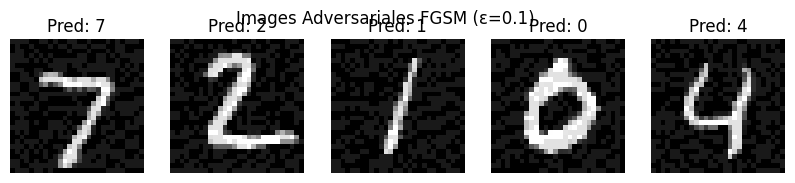


Attaque FGSM avec ε = 0.2
Robust accuracy : 0.9500


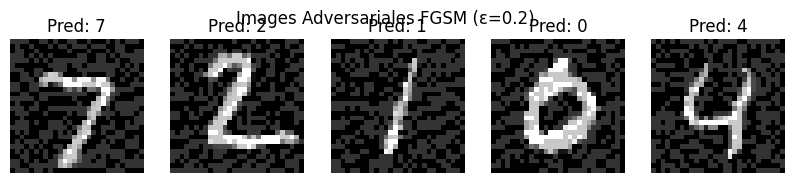


Attaque FGSM avec ε = 0.3
Robust accuracy : 0.9390


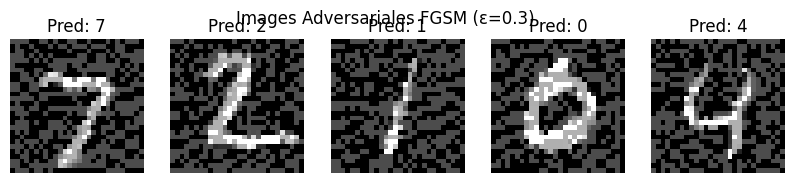


BIM avec ε = 0.2, itérations = 3
Robust accuracy : 0.7190


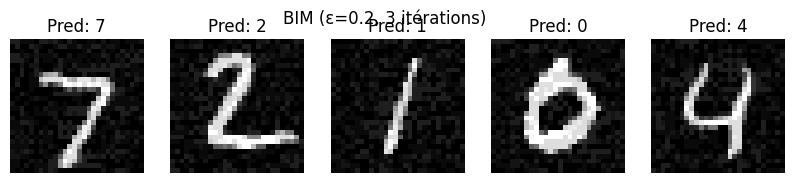


BIM avec ε = 0.2, itérations = 10
Robust accuracy : 0.0080


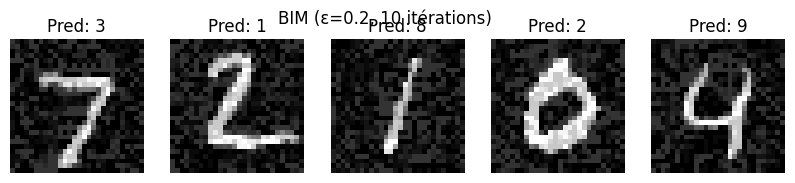


BIM avec ε = 0.2, itérations = 20
Robust accuracy : 0.0010


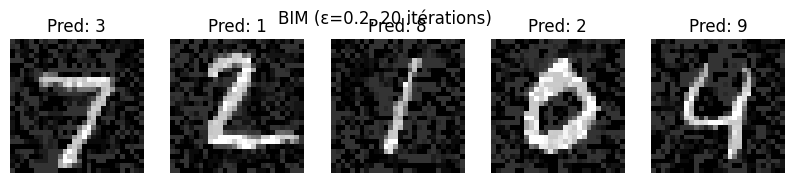


PGD avec ε = 0.2, 40 itérations
Robust accuracy : 0.0080


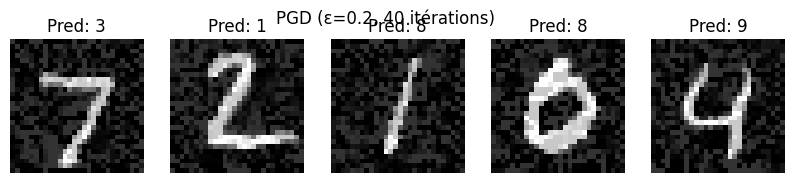

Shape de clipped après l'attaque : torch.Size([20, 100, 1, 28, 28])
Shape de clipped après squeeze : torch.Size([20, 100, 1, 28, 28])

Distance moyenne L2 des perturbations (DeepFool) : 6.8779
Robust accuracy : 0.1940


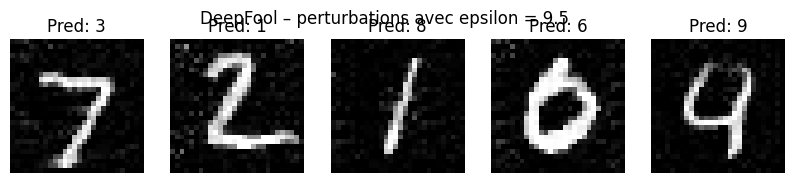

In [66]:
FGSM(model)
BIM(model)
PGD(model)
deep_fool(model)


Attaque FGSM avec ε = 0.1
Robust accuracy : 0.8610


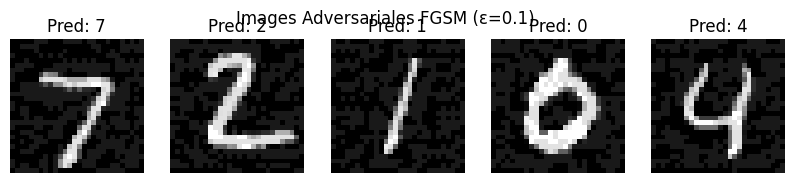


Attaque FGSM avec ε = 0.2
Robust accuracy : 0.4830


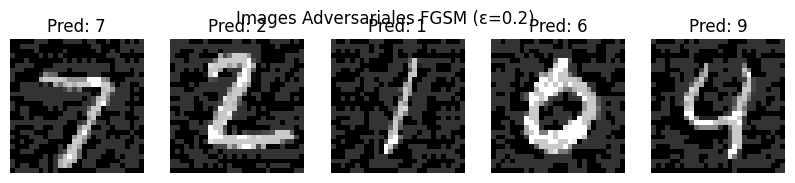


Attaque FGSM avec ε = 0.3
Robust accuracy : 0.1390


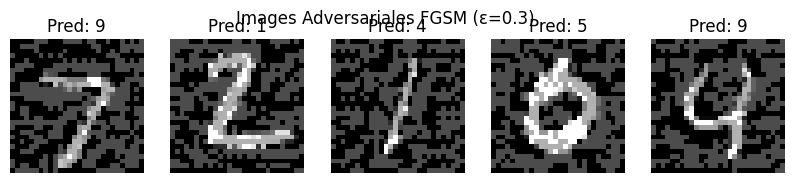


BIM avec ε = 0.2, itérations = 3
Robust accuracy : 0.7120


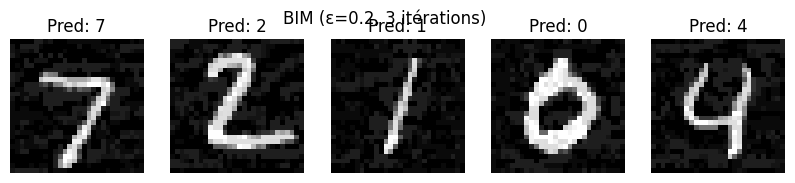


BIM avec ε = 0.2, itérations = 10
Robust accuracy : 0.0270


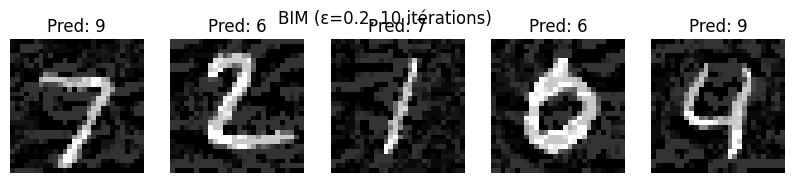


BIM avec ε = 0.2, itérations = 20
Robust accuracy : 0.0160


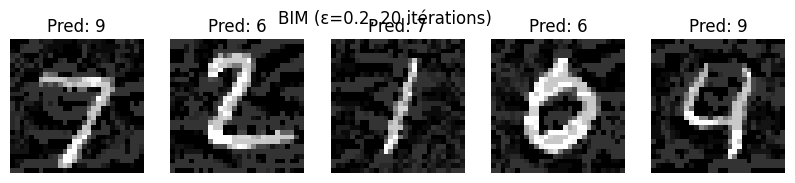


PGD avec ε = 0.2, 40 itérations
Robust accuracy : 0.0430


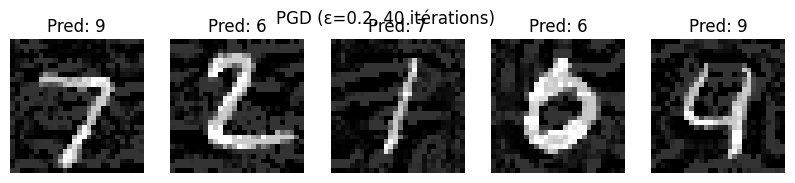

Shape de clipped après l'attaque : torch.Size([20, 100, 1, 28, 28])
Shape de clipped après squeeze : torch.Size([20, 100, 1, 28, 28])

Distance moyenne L2 des perturbations (DeepFool) : 7.2378
Robust accuracy : 0.1950


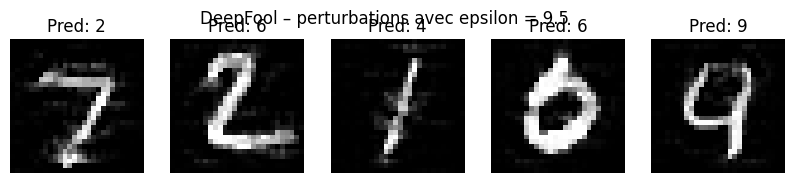

In [76]:
FGSM(adversarial_model)
BIM(adversarial_model)
PGD(adversarial_model)
deep_fool(adversarial_model)